In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [ ]:
"""
val 73.14% 1,209,351 transformer_v1: encoder dropout only (0.1)
3,218,439 transformer_v2: encoder dropout only (0.1)
"""

RUN_ID = "transformer_v2"
model_save_name = "transformer_v2"

In [6]:
class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, sigma: float = 0.6):
        self.root_dir = Path(root_dir)
        self.split = split
        self.sigma = sigma
        self.num_classes = 7
        self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')
        self.scores = np.load(self.root_dir / f"{self.split}_scores.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()
        
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        hard_label = torch.tensor(self.y[idx], dtype=torch.long)

        # return self.X[idx], self.y[idx]
        return x_tensor, soft_target, hard_label

In [7]:
BATCH_SIZE = 512
num_workers = 0 
ROOT_DIR = Path("./dataset_planes_cp/")

train_dataset = ChessDataset(root_dir=ROOT_DIR, split="train")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

val_dataset = ChessDataset(root_dir=ROOT_DIR, split="val")
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)

test_dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [8]:
import time

start = time.time()
for i, (X, y, y_hard) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.10115919351577758


In [9]:
Xb, _, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype)

X batch shape: torch.Size([512, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([512]) dtype: torch.int64


In [10]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [11]:
import math
import torch
import torch.nn as nn

class Ffn(nn.Module):
    """
    Corresponds to 'shared.py'.
    """
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, ffn_dim)
        self.activation = nn.ReLU() 
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ffn_dim, embed_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        return x

class EncoderBlock(nn.Module):
    """
    Corresponds to 'encoder.py'.
    """
    def __init__(self, embed_dim, num_heads, ffn_dim, num_blocks, dropout=0.1):
        super().__init__()
        # DeepNorm: to prevent exploding variance, Post-Norm is actually capable of higher accuracy than Pre-Norm, if you can stop it from exploding during training.
        self.alpha = math.pow(2.0 * num_blocks, -0.25)
        
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ffn = Ffn(embed_dim, ffn_dim)
        self.dropout2 = nn.Dropout(dropout)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.mha(x, x, x)
        x = x + self.dropout1(attn_out) * self.alpha
        identity = self.ln1(x)
        ffn_out = self.ffn(identity)
        x = identity + self.dropout2(ffn_out) * self.alpha # residual sum
        x = self.ln2(x)
        return x

class Transformer(nn.Module):
    def __init__(self, input_channels=19, embed_dim=128, num_heads=4, ffn_dim=512, num_blocks=6, num_classes=7):
        super().__init__()
    
        # Leela first compress the all global pieces into a vector, embed it and append it to each square again
        # This way, all squares know where all other pieces are; But can consider that as a TODO
        
        # Linear only looks at the last dimension in input tensor
        self.embedding = nn.Linear(input_channels, embed_dim)

        self.embed_activation = nn.ReLU()
        self.embed_norm = nn.LayerNorm(embed_dim)

        # We learn 64 unique vectors. We let the model figure out where they are relative to each other.
        self.pos_embedding = nn.Parameter(torch.randn(1, 64, embed_dim))
        nn.init.normal_(self.pos_embedding, mean=0, std=0.02)
        
        # Transformer Tower
        self.blocks = nn.ModuleList([EncoderBlock(embed_dim, num_heads, ffn_dim, num_blocks) for _ in range(num_blocks)])
        
        self.classifier_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )
        

    def forward(self, x):
        # Reshape (Batch, 19, 8, 8) to (Batch, 64, 19)
        x = x.permute(0, 2, 3, 1).flatten(1, 2)
    
        x = self.embedding(x) # Input: (Batch, 64, 19); Output: (Batch, 64, embed_dim)
        x = self.embed_activation(x)
        x = self.embed_norm(x)
        
        x = x + self.pos_embedding # (1, 64, embed_dim) is broadcasted to (Batch, 64, embed_dim)
 
        for block in self.blocks:
            x = block(x)
        
        # Global Pooling, Average all 64 squares to get one vector for the board
        x = x.mean(dim=1) # Input: (Batch, 64, embed_dim); Output: (Batch, embed_dim)
        
        logits = self.classifier_head(x) # Shape: (Batch, 7)
        
        return logits

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [13]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, y_hard) in enumerate(dataloader):
            X, y, y_hard = X.to(device), y.to(device), y_hard.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y_hard).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [20]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=5
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [21]:
from torchinfo import summary

hyperparams = {
    "input_channels": 19,
    "embed_dim": 256,   
    "num_heads": 8,    
    "ffn_dim": 512,     
    "num_blocks": 6,    
    "num_classes": 7   
}

model = Transformer(**hyperparams).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [512, 7]                  16,384
├─Linear: 1-1                            [512, 64, 256]            5,120
├─ReLU: 1-2                              [512, 64, 256]            --
├─LayerNorm: 1-3                         [512, 64, 256]            512
├─ModuleList: 1-4                        --                        --
│    └─EncoderBlock: 2-1                 [512, 64, 256]            --
│    │    └─MultiheadAttention: 3-1      [512, 64, 256]            263,168
│    │    └─Dropout: 3-2                 [512, 64, 256]            --
│    │    └─LayerNorm: 3-3               [512, 64, 256]            512
│    │    └─Ffn: 3-4                     [512, 64, 256]            262,912
│    │    └─Dropout: 3-5                 [512, 64, 256]            --
│    │    └─LayerNorm: 3-6               [512, 64, 256]            512
│    └─EncoderBlock: 2-2                 [512, 64, 256]          

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS+1,
                        device=device)

Starting Training: transformer_v2


  1%|          | 1/100 [25:36<42:15:16, 1536.53s/it]

Epoch: 0 | New Best Val Acc: 0.4488 (Saved)
Epoch: 0 | Train Loss: 1.4918 | Val Loss: 1.4636 | Val Acc: 0.4488


  2%|▏         | 2/100 [45:42<36:31:52, 1341.97s/it]

Epoch: 1 | New Best Val Acc: 0.5582 (Saved)
Epoch: 1 | Train Loss: 1.3390 | Val Loss: 1.2904 | Val Acc: 0.5582


  3%|▎         | 3/100 [1:05:01<33:54:36, 1258.52s/it]

Epoch: 2 | New Best Val Acc: 0.6104 (Saved)
Epoch: 2 | Train Loss: 1.2501 | Val Loss: 1.2087 | Val Acc: 0.6104


  4%|▍         | 4/100 [1:25:19<33:07:57, 1242.48s/it]

Epoch: 3 | New Best Val Acc: 0.6307 (Saved)
Epoch: 3 | Train Loss: 1.1840 | Val Loss: 1.1736 | Val Acc: 0.6307


  5%|▌         | 5/100 [1:45:51<32:41:05, 1238.59s/it]

Epoch: 4 | New Best Val Acc: 0.6511 (Saved)
Epoch: 4 | Train Loss: 1.1515 | Val Loss: 1.1414 | Val Acc: 0.6511


  6%|▌         | 6/100 [2:06:34<32:23:15, 1240.38s/it]

Epoch: 5 | New Best Val Acc: 0.6584 (Saved)
Epoch: 5 | Train Loss: 1.1316 | Val Loss: 1.1288 | Val Acc: 0.6584


  7%|▋         | 7/100 [2:26:45<31:47:20, 1230.55s/it]

Epoch: 6 | New Best Val Acc: 0.6674 (Saved)
Epoch: 6 | Train Loss: 1.1164 | Val Loss: 1.1159 | Val Acc: 0.6674


  8%|▊         | 8/100 [2:46:19<30:59:10, 1212.50s/it]

Epoch: No improvement. Patience 1/101
Epoch: 7 | Train Loss: 1.1063 | Val Loss: 1.1234 | Val Acc: 0.6568


  9%|▉         | 9/100 [3:05:52<30:20:22, 1200.25s/it]

Epoch: 8 | New Best Val Acc: 0.6737 (Saved)
Epoch: 8 | Train Loss: 1.0985 | Val Loss: 1.1056 | Val Acc: 0.6737


 10%|█         | 10/100 [3:25:31<29:50:23, 1193.59s/it]

Epoch: 9 | New Best Val Acc: 0.6772 (Saved)
Epoch: 9 | Train Loss: 1.0921 | Val Loss: 1.0999 | Val Acc: 0.6772


 11%|█         | 11/100 [3:45:09<29:23:32, 1188.91s/it]

Epoch: 10 | New Best Val Acc: 0.6778 (Saved)
Epoch: 10 | Train Loss: 1.0869 | Val Loss: 1.1013 | Val Acc: 0.6778


 12%|█▏        | 12/100 [4:04:48<28:59:23, 1185.95s/it]

Epoch: 11 | New Best Val Acc: 0.6859 (Saved)
Epoch: 11 | Train Loss: 1.0820 | Val Loss: 1.0894 | Val Acc: 0.6859


 13%|█▎        | 13/100 [4:24:28<28:37:07, 1184.22s/it]

Epoch: No improvement. Patience 1/101
Epoch: 12 | Train Loss: 1.0779 | Val Loss: 1.0953 | Val Acc: 0.6819


 14%|█▍        | 14/100 [4:44:09<28:15:52, 1183.17s/it]

Epoch: 13 | New Best Val Acc: 0.6902 (Saved)
Epoch: 13 | Train Loss: 1.0744 | Val Loss: 1.0812 | Val Acc: 0.6902


 15%|█▌        | 15/100 [5:03:51<27:55:34, 1182.76s/it]

Epoch: No improvement. Patience 1/101
Epoch: 14 | Train Loss: 1.0709 | Val Loss: 1.0826 | Val Acc: 0.6898


 16%|█▌        | 16/100 [5:23:32<27:35:17, 1182.35s/it]

Epoch: 15 | New Best Val Acc: 0.6932 (Saved)
Epoch: 15 | Train Loss: 1.0678 | Val Loss: 1.0777 | Val Acc: 0.6932


 17%|█▋        | 17/100 [5:43:16<27:16:03, 1182.70s/it]

Epoch: No improvement. Patience 1/101
Epoch: 16 | Train Loss: 1.0651 | Val Loss: 1.0884 | Val Acc: 0.6859


 18%|█▊        | 18/100 [6:02:55<26:54:59, 1181.70s/it]

Epoch: 17 | New Best Val Acc: 0.6939 (Saved)
Epoch: 17 | Train Loss: 1.0627 | Val Loss: 1.0774 | Val Acc: 0.6939


 19%|█▉        | 19/100 [6:22:31<26:33:06, 1180.09s/it]

Epoch: No improvement. Patience 1/101
Epoch: 18 | Train Loss: 1.0604 | Val Loss: 1.0721 | Val Acc: 0.6907


 20%|██        | 20/100 [6:42:08<26:12:06, 1179.08s/it]

Epoch: 19 | New Best Val Acc: 0.6994 (Saved)
Epoch: 19 | Train Loss: 1.0580 | Val Loss: 1.0693 | Val Acc: 0.6994


 21%|██        | 21/100 [7:01:43<25:50:50, 1177.86s/it]

Epoch: No improvement. Patience 1/101
Epoch: 20 | Train Loss: 1.0560 | Val Loss: 1.0778 | Val Acc: 0.6932


 22%|██▏       | 22/100 [7:21:19<25:30:17, 1177.15s/it]

Epoch: No improvement. Patience 2/101
Epoch: 21 | Train Loss: 1.0539 | Val Loss: 1.0667 | Val Acc: 0.6994


 23%|██▎       | 23/100 [7:40:53<25:09:39, 1176.36s/it]

Epoch: No improvement. Patience 3/101
Epoch: 22 | Train Loss: 1.0519 | Val Loss: 1.0735 | Val Acc: 0.6964


 24%|██▍       | 24/100 [8:00:27<24:49:11, 1175.67s/it]

Epoch: 23 | New Best Val Acc: 0.7041 (Saved)
Epoch: 23 | Train Loss: 1.0499 | Val Loss: 1.0644 | Val Acc: 0.7041


 25%|██▌       | 25/100 [8:20:02<24:29:21, 1175.49s/it]

Epoch: No improvement. Patience 1/101
Epoch: 24 | Train Loss: 1.0480 | Val Loss: 1.0718 | Val Acc: 0.6995


 26%|██▌       | 26/100 [8:39:37<24:09:23, 1175.18s/it]

Epoch: No improvement. Patience 2/101
Epoch: 25 | Train Loss: 1.0464 | Val Loss: 1.0621 | Val Acc: 0.7040


 27%|██▋       | 27/100 [8:59:10<23:48:59, 1174.52s/it]

Epoch: No improvement. Patience 3/101
Epoch: 26 | Train Loss: 1.0445 | Val Loss: 1.0714 | Val Acc: 0.6975


 28%|██▊       | 28/100 [9:18:42<23:28:37, 1173.85s/it]

Epoch: 27 | New Best Val Acc: 0.7048 (Saved)
Epoch: 27 | Train Loss: 1.0427 | Val Loss: 1.0642 | Val Acc: 0.7048


 29%|██▉       | 29/100 [9:38:14<23:08:29, 1173.37s/it]

Epoch: No improvement. Patience 1/101
Epoch: 28 | Train Loss: 1.0412 | Val Loss: 1.0584 | Val Acc: 0.7048


 30%|███       | 30/100 [9:57:48<22:48:52, 1173.32s/it]

Epoch: 29 | New Best Val Acc: 0.7067 (Saved)
Epoch: 29 | Train Loss: 1.0395 | Val Loss: 1.0589 | Val Acc: 0.7067


 31%|███       | 31/100 [10:18:05<22:44:23, 1186.43s/it]

Epoch: No improvement. Patience 1/101
Epoch: 30 | Train Loss: 1.0376 | Val Loss: 1.0633 | Val Acc: 0.7031


 32%|███▏      | 32/100 [10:38:33<22:38:50, 1198.98s/it]

Epoch: No improvement. Patience 2/101
Epoch: 31 | Train Loss: 1.0361 | Val Loss: 1.0623 | Val Acc: 0.7041


 33%|███▎      | 33/100 [10:59:04<22:29:35, 1208.59s/it]

Epoch: No improvement. Patience 3/101
Epoch: 32 | Train Loss: 1.0344 | Val Loss: 1.0610 | Val Acc: 0.7044


 34%|███▍      | 34/100 [11:19:37<22:17:32, 1215.95s/it]

Epoch: 33 | New Best Val Acc: 0.7068 (Saved)
Epoch: 33 | Train Loss: 1.0325 | Val Loss: 1.0586 | Val Acc: 0.7068


 35%|███▌      | 35/100 [11:40:10<22:02:40, 1220.93s/it]

Epoch: 34 | New Best Val Acc: 0.7104 (Saved)
Epoch: 34 | Train Loss: 1.0311 | Val Loss: 1.0565 | Val Acc: 0.7104


 36%|███▌      | 36/100 [12:00:44<21:46:40, 1225.01s/it]

Epoch: No improvement. Patience 1/101
Epoch: 35 | Train Loss: 1.0293 | Val Loss: 1.0553 | Val Acc: 0.7102


 37%|███▋      | 37/100 [12:21:18<21:29:04, 1227.70s/it]

Epoch: No improvement. Patience 2/101
Epoch: 36 | Train Loss: 1.0275 | Val Loss: 1.0566 | Val Acc: 0.7072


 38%|███▊      | 38/100 [12:41:53<21:11:00, 1230.00s/it]

Epoch: 37 | New Best Val Acc: 0.7108 (Saved)
Epoch: 37 | Train Loss: 1.0259 | Val Loss: 1.0548 | Val Acc: 0.7108


 39%|███▉      | 39/100 [13:02:30<20:52:24, 1231.87s/it]

Epoch: 38 | New Best Val Acc: 0.7137 (Saved)
Epoch: 38 | Train Loss: 1.0243 | Val Loss: 1.0533 | Val Acc: 0.7137


 40%|████      | 40/100 [13:23:08<20:33:47, 1233.78s/it]

Epoch: No improvement. Patience 1/101
Epoch: 39 | Train Loss: 1.0224 | Val Loss: 1.0530 | Val Acc: 0.7135


 41%|████      | 41/100 [13:43:46<20:14:33, 1235.14s/it]

Epoch: 40 | New Best Val Acc: 0.7168 (Saved)
Epoch: 40 | Train Loss: 1.0207 | Val Loss: 1.0497 | Val Acc: 0.7168


 42%|████▏     | 42/100 [14:04:33<19:57:25, 1238.71s/it]

Epoch: No improvement. Patience 1/101
Epoch: 41 | Train Loss: 1.0192 | Val Loss: 1.0625 | Val Acc: 0.7070


In [14]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [15]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

In [ ]:
# from pathlib import Path

# MODEL_PATH = Path("./models/transformer_v1.pth")

# hyperparams = {
#     "input_channels": 19,
#     "embed_dim": 128,   
#     "num_heads": 4,    
#     "ffn_dim": 512,     
#     "num_blocks": 6,    
#     "num_classes": 7   
# }

# model = Transformer(**hyperparams).to(device)

# try:
#     model.load_state_dict(torch.load(MODEL_PATH))
#     print(f"Loaded weights from {MODEL_PATH}")
# except FileNotFoundError:
#     print("Weight file not found! Please check MODEL_PATH.")

# model.eval()
# print("Model ready.")

Loaded weights from models\transformer_v1.pth
Model ready.


Model Prediction:  5
Stockfish Evaluation:  5


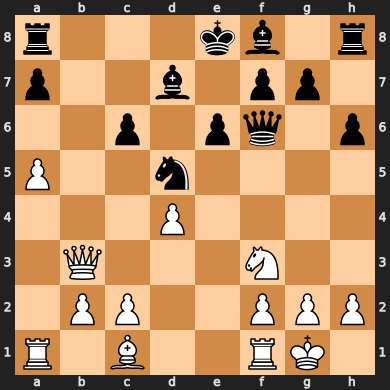

In [21]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [22]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y, y_hard in val_dataloader:
        X = X.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_hard.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.84      0.86      0.85     85601
           1       0.69      0.67      0.68     85601
           2       0.67      0.68      0.67     85601
           3       0.69      0.69      0.69     85601
           4       0.70      0.70      0.70     85601
           5       0.70      0.66      0.68     85601
           6       0.83      0.86      0.85     85601

    accuracy                           0.73    599207
   macro avg       0.73      0.73      0.73    599207
weighted avg       0.73      0.73      0.73    599207



In [23]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [24]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, _, y_hard in dataloader:
            X = X.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_hard.numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [26]:
dataset_paths = {
    "train": str(ROOT_DIR / "train_X.npy"),
    "val":   str(ROOT_DIR / "val_X.npy"),
    "test":  str(ROOT_DIR / "test_X.npy")
}

# hyperparams defined in model definition cell block
save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
# save_training_logs(experiment_name=RUN_ID, 
#                    results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/transformer_v1/transformer_v1_config.json
------------------------------------------------------------
[Results] Accuracy:        73.04%
[Results] Off-by-1 Acc:    95.83%
[Results] MAE:             0.3331
[Results] Latency:         0.1056 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 6418 samples
   - Off by 4: 1302 samples
   - Off by 5: 850 samples
   - Off by 6: 334 samples
[Results] Saved all metrics to experiments/results/transformer_v1
------------------------------------------------------------


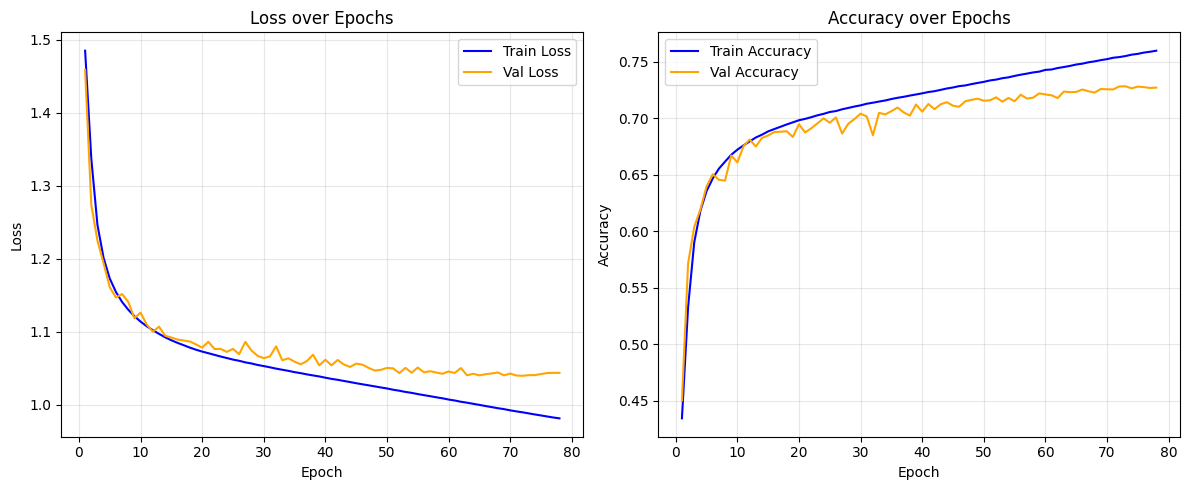

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()